# Importing libraries and reading in file

In [13]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import NaiveBayes
from pyspark import SparkContext
from pyspark.sql import SparkSession


In [14]:
# Initialize SparkSession
spark_session = SparkSession.builder \
    .appName("CSV Reader") \
    .getOrCreate()

# Read CSV file into DataFrame
dataset_df = spark_session.read.csv(
    path='C:\\Users\\priya\\Downloads\\dataset.csv',
    sep=',',
    encoding='UTF-8',
    comment=None,
    header=True,
    inferSchema=True
)

# Group by 'label' column and count occurrences
label_counts = dataset_df.groupBy('label').count()

# Convert to Pandas DataFrame for easier viewing
label_counts_pandas = label_counts.toPandas()

print(label_counts_pandas)



   label    count
0      1    56937
1      0  1000000


# Under Sample Unbalanced Datasets

In [31]:
# Assuming dataset contains the data you want to filter
url_data = dataset_df  # Replace dataset_df with your actual DataFrame

# Register DataFrame as a temporary view
url_data.createOrReplaceTempView("url_data")

# Filter malicious and benign URLs
malicious_urls = spark.sql("SELECT * FROM url_data WHERE label = 1")
benign_urls = spark.sql("SELECT * FROM url_data WHERE label = 0")

# Calculate sampling ratio
sampling_ratio = malicious_urls.count() / url_data.count()

# Sample benign URLs based on the calculated ratio
sampled_benign = benign_urls.sample(False, sampling_ratio)

# Combine malicious and sampled benign URLs
sampled_data = malicious_urls.unionAll(sampled_benign)

# Group by 'label' column and count occurrences
sampled_label_counts = sampled_data.groupBy('label').count()

# Convert to Pandas DataFrame for easier viewing
sampled_label_counts_pandas = sampled_label_counts.toPandas()

print(sampled_label_counts_pandas)



   label  count
0      1  56937
1      0  54122


# Data Ingestion and Vectorization

In [32]:
# Sample a portion of data to balance classes (assuming 'label' column exists)
sampled = dataset_df.sampleBy("label", fractions={0: 0.5, 1: 1.0}, seed=0)

#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = CountVectorizer(inputCol=regexTokenizer.getOutputCol(), outputCol="rawfeatures", vocabSize=10000, minDF=5)

#
idf = IDF(inputCol=countVectors.getOutputCol(), outputCol="features") 

#create the pipline 
pipeline = Pipeline(stages=[regexTokenizer, countVectors, idf ])


# Fit the pipeline to training documents.
# Pass 'sampled' in the param to set Balanced datasets
pipelineFit = pipeline.fit(sampled)

#Transform the pipeline to dataset
# Pass 'sampled' in the param to set Balanced datasets
dataset = pipelineFit.transform(sampled)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("\nTraining Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))




Training Dataset Count: 445231
Test Dataset Count: 111376
Total Dataset Count: 556607


In [17]:
trainingData.groupby('label').count().toPandas()

,label,count
0,1,45570
1,0,399661


# Logistic Regression


Confusion Matrix - Iteration 1
True Positives: 8161
True Negatives: 100009
False Positives: 0
False Negatives: 3206


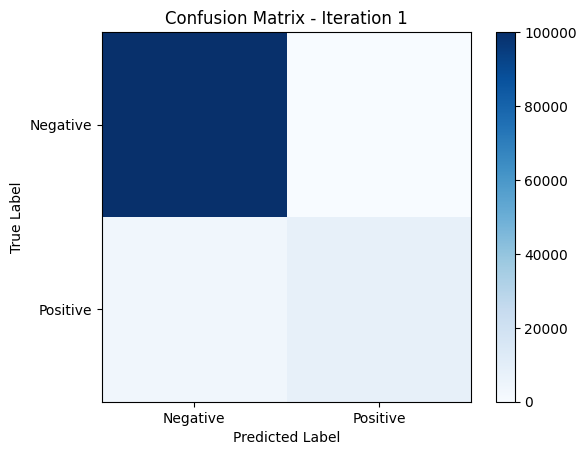


Confusion Matrix - Iteration 2
True Positives: 8161
True Negatives: 100009
False Positives: 0
False Negatives: 3206


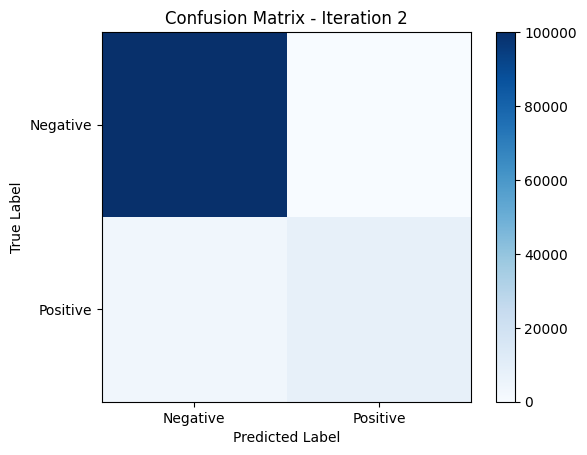


Confusion Matrix - Iteration 3
True Positives: 8161
True Negatives: 100009
False Positives: 0
False Negatives: 3206


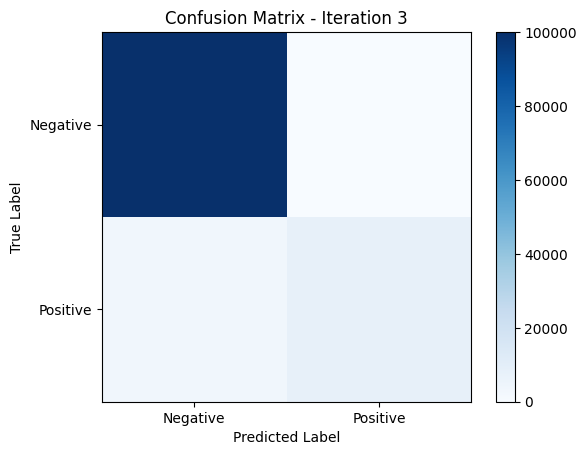


Confusion Matrix - Iteration 4
True Positives: 8161
True Negatives: 100009
False Positives: 0
False Negatives: 3206


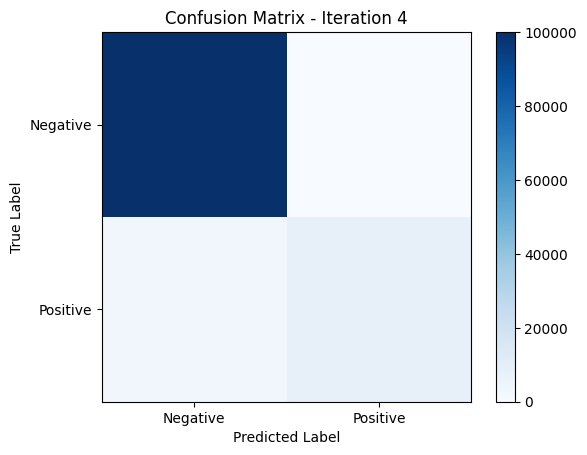


Confusion Matrix - Iteration 5
True Positives: 8161
True Negatives: 100009
False Positives: 0
False Negatives: 3206


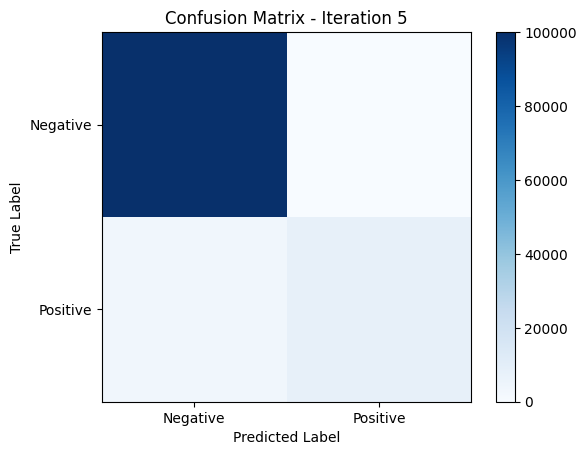


Average Accuracy: 97.1215
Average F1-Score: 83.5825481
Average Recall: 71.7955
Average Precision: 100


In [33]:
# Fit the pipeline to sampled data
from pyspark.ml.classification import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

# Create the pipeline and fit it to the sampled data
pipeline_model = pipeline.fit(sampled)

# Initialize performance metrics variables
avg_recall = 0.0
avg_precision = 0.0
avg_accuracy = 0.0
avg_f1_score = 0.0
total_recall = 0.0
total_precision = 0.0
total_accuracy = 0.0
total_f1_score = 0.0

# Build logistic regression model and evaluate
for i in range(1, 6):
    # Transform the sampled data using the fitted pipeline
    dataset = pipeline_model.transform(sampled)

    # Randomly split the dataset into training and testing sets (80%, 20%)
    (training_data, test_data) = dataset.randomSplit([0.8, 0.2], seed=100)

    # Instantiate Logistic Regression model
    lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family="binomial")

    # Train the Logistic Regression model
    lr_model = lr.fit(training_data)

    # Make predictions on test data
    predictions = lr_model.transform(test_data)

    # Calculate true positives, true negatives, false positives, false negatives
    df = predictions.select('prediction', 'label')
    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    # Calculate evaluation metrics: Recall, Precision, Accuracy, F1 Score
    recall = float(tp) / (tp + fn)
    precision = float(tp) / (tp + fp)
    accuracy = float(tp + tn) / (tp + fp + tn + fn)
    f1_score = (2 * precision * recall) / (precision + recall)

    total_recall += recall
    total_precision += precision
    total_accuracy += accuracy
    total_f1_score += f1_score

    # Print confusion matrix
    print("\nConfusion Matrix - Iteration", i)
    print("True Positives: %g" % tp)
    print("True Negatives: %g" % tn)
    print("False Positives: %g" % fp)
    print("False Negatives: %g" % fn)

    # Plot confusion matrix
    cm = np.array([[tn, fp], [fn, tp]])
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Iteration ' + str(i))
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Calculate average evaluation metrics
avg_recall = total_recall / i
avg_precision = total_precision / i
avg_accuracy = total_accuracy / i
avg_f1_score = total_f1_score / i

# Print the average evaluation metrics
print("\nAverage Accuracy: %g" % (avg_accuracy * 100))
print("Average F1-Score: %f1" % (avg_f1_score * 100))
print("Average Recall: %g" % (avg_recall * 100))
print("Average Precision: %g" % (avg_precision * 100))





# Naive Bayes

Test: Area Under ROC: 0.9830
True Positives: prediction    11109
label         11109
dtype: int64
True Negatives: prediction    98880
label         98880
dtype: int64
False Positives: prediction    1129
label         1129
dtype: int64
False Negatives: prediction    258
label         258
dtype: int64
Total: 111376
F1-Score: 94.10
Accuracy: 98.75%
Recall: 97.73%
Precision: 90.77%


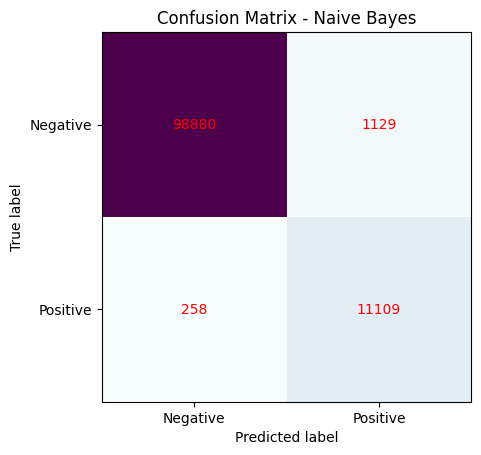

In [30]:

from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial")

# Train the model
model = nb.fit(trainingData)

# Select example rows to display.
predictions = model.transform(testData)

# Compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_roc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Test: Area Under ROC: {:.4f}".format(area_under_roc))

# Extract prediction and label columns
df = predictions.select('prediction', 'label').toPandas()

# Calculate confusion matrix values
tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("True Positives: {}".format(tp))
print("True Negatives: {}".format(tn))
print("False Positives: {}".format(fp))
print("False Negatives: {}".format(fn))
print("Total: {}".format(df.shape[0]))

# Calculate evaluation metrics
# Calculate evaluation metrics
r = float(tp.iloc[0]) / (tp.iloc[0] + fn.iloc[0])
p = float(tp.iloc[0]) / (tp.iloc[0] + fp.iloc[0])
a = float(tp.iloc[0] + tn.iloc[0]) / (tp.iloc[0] + fp.iloc[0] + tn.iloc[0] + fn.iloc[0])


print("F1-Score: {:.2f}".format(f1 * 100))
print("Accuracy: {:.2f}%".format(a * 100))
print("Recall: {:.2f}%".format(r * 100))
print("Precision: {:.2f}%".format(p * 100))

# Plot confusion matrix
plt.clf()
cm = confusion_matrix(df['label'], df['prediction'])

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'])
plt.yticks(tick_marks, ['Negative', 'Positive'])

# Display counts on each cell of the confusion matrix
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red')

plt.show()
